In [68]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
import math

<Strong> Grabbing the data from stored files (originally pulled from Binance) </Strong>

In [69]:
df_btc = pd.read_csv("BTC_1h_data.csv")

In [70]:
df_btc

,date,open,high,low,close,volume
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...,...
39216,2022-02-11 10:00:00,43492.63,43569.67,43233.67,43443.77,1305.626920
39217,2022-02-11 11:00:00,43443.78,43523.42,43320.00,43357.53,744.524180
39218,2022-02-11 12:00:00,43357.53,43700.78,43253.31,43570.77,1317.546940
39219,2022-02-11 13:00:00,43570.77,43826.00,43503.01,43765.14,1564.251800


In [71]:
df_headers = df_btc.columns

<Strong> Grabbing the closing price (univariate) </Strong>

In [72]:
# Removing everything but the closing price
btc_data = df_btc.values[:, 4 ,].astype(float)

btc_data[-1]

43534.54

<Strong> Scaling the data  </Strong>

In [73]:
percTrain = 70
percVal = 20 

In [74]:
scaler = MinMaxScaler()
    
onePercent = len(btc_data) // 100
numberTraining = onePercent * percTrain

reshaped_data = btc_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_btc = scaler.transform(reshaped_data)

<Strong> Creating Matrix in Sliding window form <Strong>

In [75]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

In [76]:
# Using 24 datapoints to predict the 25th

window_length = 24
features = 1

sliding_winda_btc = sliding_window(scaled_btc , window_length)

<Strong> Splitting the data after we create Sliding Window matrix (more data) </Strong>

In [77]:
# Splitting the data after creating the sliding window data
def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

In [78]:
#Reshaping the data so we can use min-max a
btc_train , btc_val , btc_test = splitting_train_test(sliding_winda_btc)

print(btc_train[0].shape)

(27370, 24, 1)


<Strong> Creating the model </Strong>

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 24, 30)       3840        ['input_2[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 24, 30)       0           ['lstm_2[0][0]']                 
                                                                                                  
 gru_1 (GRU)                    (None, 30)           2970        ['input_2[0][0]']                
                                                                                            

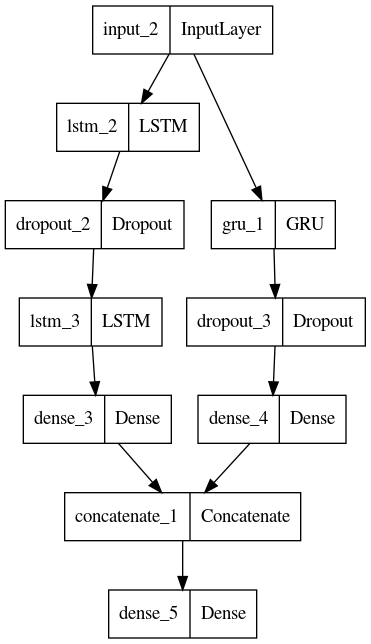

In [79]:
inputs = Input(shape = (window_length , features) )

x = LSTM(30 , return_sequences = True )(inputs)
x = Dropout(0.01)(x) 
x = LSTM(50)(x)
x = Dense(128)(x)

y = GRU(30,input_shape=(window_length , features))(inputs)
y = Dropout(0.01)(y)
y = Dense(128)(y)

final = Concatenate()([x,y])
final = Dense(1)(final)

model = tf.keras.Model(inputs=inputs, outputs= final)

model.summary()
plot_model(model)

<Strong> Compiling the model </Strong>

In [80]:
#Validation set needs to be in a tuple with x , y

model.compile(optimizer='adam' , loss = 'mse')

<Strong> Creating a callback , so we can avail of early stopping </Strong>

In [81]:
earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)

<Strong> Fitting the Model , and storing the epoch training stopped on </Strong>

In [82]:
history = model.fit(btc_train[0] , btc_train[1] , validation_data = btc_val  , batch_size = 512  , epochs =300 , verbose = 1 , callbacks=[earlyStopping])
num_epochs = earlyStopping.stopped_epoch


Epoch 1/300
54/54 [==============================] - 5s 25ms/step - loss: 0.0083 - val_loss: 0.1594
Epoch 2/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0234e-04 - val_loss: 0.1804
Epoch 3/300
54/54 [==============================] - 0s 8ms/step - loss: 7.8995e-05 - val_loss: 0.1710
Epoch 4/300
54/54 [==============================] - 0s 8ms/step - loss: 7.7647e-05 - val_loss: 0.1618
Epoch 5/300
54/54 [==============================] - 0s 8ms/step - loss: 7.6508e-05 - val_loss: 0.1555
Epoch 6/300
54/54 [==============================] - 0s 8ms/step - loss: 7.3930e-05 - val_loss: 0.1490
Epoch 7/300
54/54 [==============================] - 0s 8ms/step - loss: 7.4176e-05 - val_loss: 0.1372
Epoch 8/300
54/54 [==============================] - 0s 8ms/step - loss: 7.1137e-05 - val_loss: 0.1316
Epoch 9/300
54/54 [==============================] - 0s 8ms/step - loss: 7.0530e-05 - val_loss: 0.1227
Epoch 10/300
54/54 [==============================] - 0s 8ms/step - loss: 6.

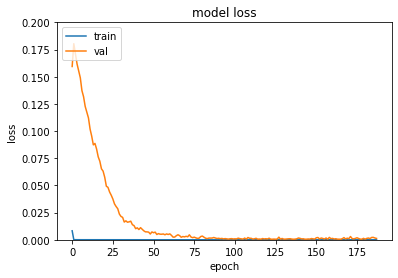

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0,0.2])
plt.show()

<Strong> Testing our model on the validation data once again , hyper-parameter adjustment. <Strong>

In [84]:
validation_predict = model.predict(btc_val[0])
validation_predict = scaler.inverse_transform(validation_predict)

validation_actual = scaler.inverse_transform(btc_val[1])
math.sqrt(mean_squared_error(validation_actual , validation_predict))

595.3376850238625

<Strong> Combining the train and validation set when perfected hyper-parameters and training on fresh model. </Strong>

In [85]:
train_and_val = np.concatenate([btc_train[0] , btc_val[0]] )
train_and_val_targets = np.concatenate([btc_train[1] , btc_val[1] ])

freshModel = tf.keras.Model(inputs=inputs, outputs= final)
freshModel.compile(optimizer='adam' , loss = 'mse')

final = freshModel.fit(train_and_val , train_and_val_targets , batch_size = 512  , epochs = num_epochs )

Epoch 1/187
69/69 [==============================] - 4s 8ms/step - loss: 0.0010
Epoch 2/187
69/69 [==============================] - 0s 7ms/step - loss: 2.7126e-04
Epoch 3/187
69/69 [==============================] - 0s 7ms/step - loss: 2.5518e-04
Epoch 4/187
69/69 [==============================] - 0s 7ms/step - loss: 2.6567e-04
Epoch 5/187
69/69 [==============================] - 0s 7ms/step - loss: 2.6337e-04
Epoch 6/187
69/69 [==============================] - 0s 7ms/step - loss: 2.6258e-04
Epoch 7/187
69/69 [==============================] - 0s 7ms/step - loss: 2.4081e-04
Epoch 8/187
69/69 [==============================] - 0s 7ms/step - loss: 2.5022e-04
Epoch 9/187
69/69 [==============================] - 0s 7ms/step - loss: 2.4687e-04
Epoch 10/187
69/69 [==============================] - 0s 7ms/step - loss: 2.6865e-04
Epoch 11/187
69/69 [==============================] - 0s 7ms/step - loss: 2.7838e-04
Epoch 12/187
69/69 [==============================] - 0s 7ms/step - loss: 2.34

<Strong> Finally testing on test set and grabbing evaluation metrics - 1 day </Strong>

In [87]:
test_predict = freshModel.predict(btc_test[0])
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(btc_test[1])

In [88]:
print(math.sqrt(mean_absolute_error(test_actual , test_predict)))
print(math.sqrt(mean_absolute_percentage_error(test_actual , test_predict)))
print(math.sqrt(mean_squared_error(test_actual , test_predict , squared = False)))
print(math.sqrt(mean_squared_error(test_actual , test_predict)))

16.046399497859213
0.07206857953008987
19.12155739876382
365.6339573542193


<Strong> For Predicting more than 1 day in the future - Test Set. </Strong>

In [137]:
def steps_in_future(hours_in_future , data):
    
    #All the hours_in_future time predictions
    predictions = []
    
    # Have to cut off the (hours_in_future - 1) off the test set to avoid out of bounds error
    test_data = data[0][:-(hours_in_future - 1)]
    
    for x in range (len(test_data)):
        #Going through all the windows
        last_window = test_data[x].reshape(1,-1)
    
            # Make as many predictions as hours_in_future
        for i in range(hours_in_future):
            
            # Take the predicted value from the last window in training set
            last_prediction = model.predict(last_window)[0]

            #shifting the window size one step down
            last_window[0] = np.roll(last_window[0], -1)

            #replacing the old value with new prediction
            last_window[0 , (len(last_window[0]) - 1)] = last_prediction

        #append prediction
        predictions.append(last_prediction)
    
    return predictions

In [153]:
#three_day_predictions = steps_in_future(3, btc_test)
seven_day_predictions = steps_in_future( 7, btc_test)

In [155]:
print(seven_day_predictions)

[array([2.9957883], dtype=float32), array([2.9848106], dtype=float32), array([2.9936342], dtype=float32), array([3.0028572], dtype=float32), array([3.0061724], dtype=float32), array([2.9942398], dtype=float32), array([2.987292], dtype=float32), array([2.9912996], dtype=float32), array([3.0027912], dtype=float32), array([2.9889307], dtype=float32), array([2.9999175], dtype=float32), array([3.035621], dtype=float32), array([3.025803], dtype=float32), array([2.9842572], dtype=float32), array([2.9644713], dtype=float32), array([2.9606185], dtype=float32), array([2.9687662], dtype=float32), array([2.9718208], dtype=float32), array([2.9744396], dtype=float32), array([2.9750822], dtype=float32), array([2.9800696], dtype=float32), array([2.9783604], dtype=float32), array([2.9583573], dtype=float32), array([2.9702516], dtype=float32), array([2.968211], dtype=float32), array([2.9640875], dtype=float32), array([2.9770818], dtype=float32), array([2.9886055], dtype=float32), array([2.9957185], dtyp

In [143]:
scaled_three_day_predictions = scaler.inverse_transform(three_day_predictions)

In [156]:
scaled_seven_day_predictions = scaler.inverse_transform(seven_day_predictions)

In [157]:
print(scaled_three_day_predictions)
print(scaled_seven_day_predictions)

[[52393.09400678]
 [52195.99807203]
 [52354.73565912]
 ...
 [44546.86637223]
 [44550.05689645]
 [44505.88995326]]
[[53219.78405225]
 [53035.46222389]
 [53183.61543703]
 ...
 [44456.13058555]
 [44915.38192761]
 [45088.53491962]]


In [139]:
# Targets to compare  
targets_in_future_three = btc_test[1][(3 - 1):]
targets_in_future_three = scaler.inverse_transform(targets_in_future_three)

targets_in_future_seven = btc_test[1][(7 - 1):]
targets_in_future_seven = scaler.inverse_transform(targets_in_future_seven)

[48956.39]


In [159]:
print(targets_in_future_seven)
#print(targets_in_future_three)

[[48721.41]
 [48929.59]
 [48686.01]
 ...
 [43570.77]
 [43765.14]
 [43534.54]]


In [161]:
#print(math.sqrt(mean_absolute_error(targets_in_future_three , scaled_three_day_predictions)))
print(math.sqrt(mean_absolute_error(targets_in_future_seven , scaled_seven_day_predictions)))

#print(math.sqrt(mean_squared_error(targets_in_future_three , scaled_three_day_predictions )))
print(math.sqrt(mean_squared_error(targets_in_future_seven , scaled_seven_day_predictions )))

#print(math.sqrt(mean_squared_error(targets_in_future_three , scaled_three_day_predictions , squared = False)))
print(math.sqrt(mean_squared_error(targets_in_future_seven , scaled_seven_day_predictions , squared = False)))

#print(math.sqrt(mean_absolute_percentage_error(targets_in_future_three , scaled_three_day_predictions)))
print(math.sqrt(mean_absolute_percentage_error(targets_in_future_seven , scaled_seven_day_predictions)))

49.77291570850026
2862.5306011223647
53.50262237612625
0.22378378125815537
